# SPEED analysis

First we ASSEMBLE it, after that its been LABELED. Then its PACKAGED and these going into a CARTON. At last the Cartons get PALLETIZED   
It goes from Assembly (Harro Hoefliger) to Labeler (Krones) to Packaging (Schubert Verpacker) to Cartoner (Pester Umverpacker) to Palletizer (Pester)




|IP_TAG Name   |Machine|German|Optimum Speed|Alarm File location|
|--------------|-------|------|-------------|-------------------| 
|36630901_SPEED|Assembly|Montage (HH)|32 used but 35|Y:\E00_Solostar\E6_Assembly_Line_6\E63_Montage\CSV|   
|36640901_SPEED|Labeler|Etikettierer (Kronos?)|500|Y:\E00_Solostar\E6_Assembly_Line_6\E64_Etikettierer\AuditTrail|   
|36650901_SPEED|Packaging (Pacemaker!)|Kartonierer (Schubert)|450 (3pcs) or 500 (5pcs)|Y:\E00_Solostar\E6_Assembly_Line_6\E65_Kartonierer\40 - Reports|   
|36670901_SPEED|part of Packaging|Bedruckung|450 (3pcs) or 500 (5pcs)|Y:\E00_Solostar\E6_Assembly_Line_6\E67_Bedruckung\40 - Reports|   
|36680901_SPEED|Cartoner|Endverpacker (UVP)|upstream can only produce 500 max, so this max must be 500|Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\UVP|   
|36680902_SPEED|Palletizer|PAL|upstream can only produce 500 max, so this max must be 500|Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\PAL|       

adjust the IP_TREND_VALUE (speeds) to show multiple assembly lines (16) or pens per packets (3 or 5), or packets per carton (always 40), or cartons per Pallet (always 50)

In [109]:
import pandas as pd
import numpy as np
import os
import re
from glob import iglob

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns

# my modules
import set_config
from common_functions import create_df_from_file


In [107]:
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']
dir_local = set_config.ConfigSectionMap("SectionOne")['local']

merge_missing_dates = True

In [110]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'

# call function with dir, folder, search criteria to find files, name of dataframe to create
df_speed = create_df_from_file(dir_sanofi_share, folder, "_SPEED")
df_speed

,Name,IP_TREND_TIME,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS
0,36630901_SPEED,19-AUG-21 20:19:32.5,32,Good,Good
1,36630901_SPEED,19-AUG-21 20:19:31.4,30,Good,Good
2,36630901_SPEED,19-AUG-21 20:19:30.4,0,Good,Good
3,36630901_SPEED,19-AUG-21 20:19:29.4,27,Good,Good
4,36630901_SPEED,19-AUG-21 20:19:17.0,32,Good,Good
...,...,...,...,...,...
27724,36680902_SPEED,02-SEP-21 09:38:58.1,1,Good,Good
27725,36680902_SPEED,02-SEP-21 09:37:36.3,0,Good,Good
27726,36680902_SPEED,02-SEP-21 09:36:39.1,1,Good,Good
27727,36680902_SPEED,02-SEP-21 09:36:18.6,2,Good,Good


In [111]:
# get the packaging DESIGNATION file which shows the pcs format
folder = 'IP21_data'
# call function with dir, folder, search criteria to find files, name of dataframe to create
df_designation = create_df_from_file(dir_sanofi_share, folder, "36650901_DESIGNATION")


Tags for Machine speeds:

|IP_TAG Name   |Machine|Optimum Speed|
|--------------|-------|------------|
|36630901_SPEED|Assembly|32 steps x16 lines (= 512) used but max could be 35 steps|   
|36640901_SPEED|Labeler|500 pcs / min|   
|36650901_SPEED|Packaging (Pacemaker!)|3pcs per package x 150 steps = 450/min, or 5pcs per package x 100 steps = 500/min|   
|36680901_SPEED|Cartoner|aka UVP - 500 max derived from upstream|   
|36680902_SPEED|Palletizer|aka PAL - 500 max derived from upstream|    

In [112]:
# convert dates to datetime format
df_speed['IP_TREND_TIME'] = pd.to_datetime(df_speed['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_designation['IP_TREND_TIME'] = pd.to_datetime(df_designation['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_designation = df_designation.sort_values('IP_TREND_TIME')
# df_speed.set_index('IP_TREND_TIME', inplace=True)

In [113]:
# df_designation.info()
df_speed = pd.merge_asof(df_speed.sort_values('IP_TREND_TIME'), df_designation[['IP_TREND_TIME','IP_TREND_VALUE']].sort_values('IP_TREND_TIME'),on='IP_TREND_TIME', allow_exact_matches=True)
# rename IP_TREND_VALUE_y Format to avoid confusion
df_speed.rename(columns={'IP_TREND_VALUE_y':'Format',
                         'IP_TREND_VALUE_x':'IP_TREND_VALUE'}, inplace=True)

In [114]:
# label the rows with the Machine name
df_speed['Machine'] = ''
df_speed.loc[df_speed['Name'] == '36630901_SPEED', 'Machine'] = 'Assembly'
df_speed.loc[df_speed['Name'] == '36640901_SPEED', 'Machine'] = 'Labeler'
df_speed.loc[df_speed['Name'] == '36650901_SPEED', 'Machine'] = 'Packaging'
df_speed.loc[df_speed['Name'] == '36680901_SPEED', 'Machine'] = 'Cartoner'
df_speed.loc[df_speed['Name'] == '36680902_SPEED', 'Machine'] = 'Palletizer'

# set the Max_Speeds
df_speed['Max_Speed'] = ''
df_speed.loc[df_speed['Machine'] == 'Assembly', 'Max_Speed'] = (32*16)
df_speed.loc[df_speed['Machine'] == 'Labeler', 'Max_Speed'] = 500
# set the packaging machine to default 450 Max_Speed
df_speed.loc[df_speed['Machine'] == 'Packaging', 'Max_Speed'] = 450
# dont know what the max speeds of Cartoner and Palletizer are, so derived from upstream max
df_speed.loc[df_speed['Machine'] == 'Cartoner', 'Max_Speed'] = 450
df_speed.loc[df_speed['Machine'] == 'Palletizer', 'Max_Speed'] = 450
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = 500
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Cartoner'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = 500
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Palletizer'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Palletizer'), 'Max_Speed'] = 500


# adjust the IP_TREND_VALUE (speeds) to show multiple assembly lines (16) or pens per packets (3 or 5), or packets per carton (always 40), or cartons per Pallet (50)
# assembly value is multipied by 16 (lines)
df_speed.loc[df_speed.Machine == 'Assembly', 'Derived_Speed'] = df_speed.loc[df_speed.Machine == 'Assembly', 'IP_TREND_VALUE'].mul(16)
# Packaging IP_TREND_VALUE is multiplied by pcs format - we can use the Max_Speed now to work that out
# df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(5)
# df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(3)
# df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(3*40)
# df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(5*40)
# df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(3*40)
# df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(5*40)

# create a new derived_speed col and leave the IP_TREND_VALUE as raw data
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(5)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(3)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(3*40)
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(5*40)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(3*40)
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'Derived_Speed'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(5*40)

# and just copy the IP_TREND_VALUE across for the assembly and labeler as no adjustments made
df_speed.loc[df_speed['Machine'] == 'Labeler', 'Derived_Speed'] = df_speed.loc[df_speed['Machine'] == 'Labeler', 'IP_TREND_VALUE']
# make Max_Speed numeric for charting later
df_speed['Max_Speed'] = pd.to_numeric(df_speed['Max_Speed'])

In [115]:
if merge_missing_dates:
    # take dates found in df_speed
    start_date = df_speed.IP_TREND_TIME.min()
    end_date = df_speed.IP_TREND_TIME.max()

    daterange = pd.date_range(start = start_date, end = end_date, freq='S')

    df_dates = pd.DataFrame(daterange)
    df_dates.rename(columns={0:'datetime'}, inplace=True)
    # df_dates.set_index(0, inplace=True)

    df_speed2 = pd.merge_asof(df_speed.sort_values('IP_TREND_TIME'), df_dates.sort_values('datetime'), right_on='datetime', left_on='IP_TREND_TIME', tolerance=pd.Timedelta("1s"), direction='backward', allow_exact_matches=True)
    df_speed = pd.merge(df_dates, df_speed2, on='datetime', how='left')

else:
    # just rename IP_TREND_TIME datetime so rest of code works
    df_speed.rename(columns={'IP_TREND_TIME':'datetime'}, inplace=True)

# idnex datetime regardless
df_speed.set_index('datetime', inplace=True)

In [116]:
# df_speed.loc[df_speed.Machine == 'Assembly', 'Derived_Speed'] = df_speed.loc[df_speed.Machine == 'Assembly', 'IP_TREND_VALUE'].mul(16)
df_speed[['Derived_Speed','IP_TREND_VALUE']][df_speed.Machine == 'Assembly'].sort_index().head(50)

,Derived_Speed,IP_TREND_VALUE
datetime,,
2021-08-01 00:08:09.800,0.0,0.0
2021-08-01 00:18:09.800,0.0,0.0
2021-08-01 00:28:09.800,0.0,0.0
2021-08-01 00:28:54.800,96.0,6.0
2021-08-01 00:28:55.800,512.0,32.0
2021-08-01 00:28:59.800,0.0,0.0
2021-08-01 00:29:00.800,256.0,16.0
2021-08-01 00:29:01.800,512.0,32.0
2021-08-01 00:29:02.800,160.0,10.0


# CHANGEOVER

In [117]:
# CHANGEOVER
folder = 'IP21_data'

df_BATCHACTIVE = create_df_from_file(dir_sanofi_share, folder, "36680902_BATCHACTIVE")

df_CNTR_GOOD = create_df_from_file(dir_sanofi_share, folder, "36680902_CNTR_GOOD")

df_CNTR_GOOD['IP_TREND_TIME'] = pd.to_datetime(df_CNTR_GOOD['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_BATCHACTIVE['IP_TREND_TIME'] = pd.to_datetime(df_BATCHACTIVE['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_CNTR_GOOD.sort_values('IP_TREND_TIME', inplace=True)
df_BATCHACTIVE.sort_values('IP_TREND_TIME', inplace=True)

In [118]:
df_changeover = []
# find where previous row was -1 (active) and this row is 0 (inactive) - this is the start of changeover
df_changeover = df_BATCHACTIVE[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_BATCHACTIVE['IP_TREND_VALUE'].shift(1) == -1) & (df_BATCHACTIVE['IP_TREND_VALUE'] == 0)]

# find where previous row was 0 (batch not started) and this row is >0 (batch running) - changeover has finished
df_changeover = df_changeover.append(df_CNTR_GOOD[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_CNTR_GOOD['IP_TREND_VALUE'].shift(1) == 0) & (df_CNTR_GOOD['IP_TREND_VALUE'] > 0)])
# convert IP_TREND_TIME to datetime format before sorting, otherwise doesn't work as expected
df_changeover['IP_TREND_TIME'] = pd.to_datetime(df_changeover['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_changeover.sort_values('IP_TREND_TIME', inplace=True)

# now, in case there are many BATCHACTIVEs for 1 CNTR_GOOD, only get the first BATCHACTIVE (>0) after a batch reset (0)
df_changeover2 = df_changeover[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_changeover['IP_TREND_VALUE'].shift(1) == 0) & (df_changeover['IP_TREND_VALUE'] > 0)]
df_changeover2 = df_changeover2.append(df_changeover[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_changeover['IP_TREND_VALUE'].shift(1) == 1) & (df_changeover['IP_TREND_VALUE'] == 0)])

# add the first row of changeover if it is a BATCHACTIVE, otherwise it gets dropped by above logic
df_changeover2 = df_changeover2.append(df_changeover[:1].loc[df_changeover[:1].Name == '36680902_BATCHACTIVE'])

# convert dates to datetime format
df_changeover2['IP_TREND_TIME'] = pd.to_datetime(df_changeover2['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_changeover2.sort_values('IP_TREND_TIME', inplace=True)


# find the speed and time diff, turn into minutes
df_changeover2['time_diff_mins'] = df_changeover2.IP_TREND_TIME.diff().dt.seconds / 60
df_changeover2['time_diff_mins'].fillna(0, inplace=True)
df_changeover2['time_diff_mins'] = np.array(df_changeover2['time_diff_mins'], dtype=int)
# df_changeover2.set_index('IP_TREND_TIME', inplace=True)

# reshape the changeover dataframe so that we have a start and end time on 1 line - easier for charting later
df_changeover3 = pd.DataFrame({'start':df_changeover2.IP_TREND_TIME.iloc[::2].values, 'end':df_changeover2.IP_TREND_TIME.iloc[1::2].values, 'time_diff_mins':df_changeover2.time_diff_mins.iloc[1::2].values})
for i, row in df_changeover3.iterrows():
    print (i, row[0], row[1])

0 2021-08-02 22:47:04.100000 2021-08-02 23:33:13.200000
1 2021-08-03 19:48:39.600000 2021-08-03 21:08:45.100000
2 2021-08-04 00:56:14.200000 2021-08-04 02:05:46.100000
3 2021-08-04 07:01:24.900000 2021-08-04 07:37:14.500000
4 2021-08-05 20:07:04.200000 2021-08-05 20:50:02
5 2021-08-06 00:30:29.400000 2021-08-06 03:04:38.500000
6 2021-08-06 11:04:49.200000 2021-08-06 12:55:08.100000
7 2021-08-07 01:48:36.400000 2021-08-07 03:10:52.900000
8 2021-08-10 09:33:14.700000 2021-08-10 10:49:15.300000
9 2021-08-12 10:17:53 2021-08-12 11:01:49
10 2021-08-12 16:07:40.400000 2021-08-12 19:32:39.600000
11 2021-08-16 09:27:53.300000 2021-08-16 10:27:43.600000
12 2021-08-18 11:46:40.400000 2021-08-18 12:57:14
13 2021-09-02 12:19:28.200000 2021-09-02 13:22:38.700000
14 2021-09-03 21:28:44.200000 2021-09-03 22:42:38.400000
15 2021-09-04 03:19:34.700000 2021-09-04 04:36:38.500000
16 2021-09-04 08:37:57.800000 2021-09-04 10:16:56.400000
17 2021-09-04 15:20:04.900000 2021-09-04 15:54:10.100000
18 2021-09-0

# STATE

In [119]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'

df_omac = create_df_from_file(dir_sanofi_share, folder, "_OMACSTATE")

df_run = create_df_from_file(dir_sanofi_share, folder, "36640901_RUN")



In [120]:
# convert dates to datetime format
df_omac['IP_TREND_TIME'] = pd.to_datetime(df_omac['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_omac.set_index('IP_TREND_TIME', inplace=True)

# convert dates to datetime format
df_run['IP_TREND_TIME'] = pd.to_datetime(df_run['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_run.set_index('IP_TREND_TIME', inplace=True)

In [121]:
df_omac['Machine'] = ''
df_omac.loc[df_omac['Name'] == '36630901_OMACSTATE', 'Machine'] = 'Assembly'
df_omac.loc[df_omac['Name'] == '36650901_OMACSTATE', 'Machine'] = 'Packaging'

df_run['Machine'] = ''
df_run.loc[df_run['Name'] == '36640901_RUN', 'Machine'] = 'Labeler'

In [122]:
# loop through the machines, sort the datetime index, and find the time diff, write it out as secs (rather than leaving it as timedelta)
machines = df_omac.Machine.unique()

for x in machines:
    # df_omac['Time_Diff_Secs'] = df_omac.index[df_omac.Machine == x].sort_values().to_series().diff().dt.seconds
    df_omac.loc[df_omac.Machine == x, 'time_diff_secs'] = df_omac.index[df_omac.Machine == x].sort_values().to_series().diff().dt.seconds

In [123]:
df_speed = pd.merge_asof(df_speed, df_omac['IP_TREND_VALUE'].sort_index(), left_index=True, right_index=True, direction='forward')
df_speed.rename(columns={
    'IP_TREND_VALUE_x':'IP_TREND_VALUE',
    'IP_TREND_VALUE_y':'State'}, inplace=True)

In [141]:
# create a pens col derived from the Format column- if it contains '5' then it's 5 pens, else we assume it's 3 even if we haven't been told...
# so this might be a wrong assumption
# forward fill the Format col
df_speed.Format.ffill(inplace=True)
df_speed['pens'] = np.where((df_speed.Format.str.contains('5')), 5, 3)

# find where previous row pens value is different to this row
df_speed[df_speed.pens.shift(1) != df_speed.pens]
# df_speed[df_speed.Format.shift(1) != df_speed.Format]



,Name,IP_TREND_TIME,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Format,Machine,Max_Speed,Derived_Speed,State,pens
datetime,,,,,,,,,,,
2021-08-01 00:07:42.800,36650901_SPEED,2021-08-01 00:07:42.800,0.0,Good,Good,NaN,Packaging,450.0,0.0,3.0,5
2021-08-05 03:41:00.800,36650901_SPEED,2021-08-05 03:41:00.800,144.0,Bad,Bad,FS 3er Toujeo,Packaging,450.0,432.0,6.0,3
2021-08-12 16:56:51.800,36640901_SPEED,2021-08-12 16:56:52.600,0.0,Good,Good,FS 5er Solo,Labeler,500.0,0.0,3.0,5
2021-08-18 11:52:21.800,36630901_SPEED,2021-08-18 11:52:22.100,0.0,Good,Good,Umstellprogramm,Assembly,512.0,0.0,9.0,3
2021-08-18 12:00:19.800,36680901_SPEED,2021-08-18 12:00:20.400,0.0,Good,Good,FS 5er Solo,Cartoner,500.0,0.0,9.0,5
2021-09-02 09:33:43.800,36680901_SPEED,2021-09-02 09:33:44.200,3.0,Good,Good,FS 3er Toujeo,Cartoner,450.0,360.0,4.0,3
2021-09-06 23:34:06.800,36640901_SPEED,2021-09-06 23:34:07.100,45.0,Good,Good,FS 5er Toujeo,Labeler,500.0,45.0,9.0,5
2021-09-10 00:31:20.800,36680901_SPEED,2021-09-10 00:31:21.100,0.0,Good,Good,Umstellprogramm,Cartoner,450.0,0.0,8.0,3
2021-09-10 00:34:02.800,36630901_SPEED,2021-09-10 00:34:03.400,0.0,Good,Good,FS 5er Toujeo,Assembly,512.0,0.0,15.0,5


In [142]:
# this might be useful for charting with the end of lines labeled and option to turn legend on and off
def improve_legend(ax=None):
    if ax is None:
        ax = plt.gca()

    # for spine in ax.spines:
        # ax.spines[spine].set_visible(False)
        
    for line in ax.lines:
        data_x, data_y = line.get_data()
        right_most_x = data_x[-1]
        right_most_y = data_y[-1]
        ax.annotate(
            line.get_label(),
            xy=(right_most_x, right_most_y),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            color=line.get_color(),
        )
    ax.legend().set_visible(False)

In [143]:
%matplotlib qt
# %matplotlib inline

freq='1s'
group = df_speed.groupby(['Machine', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('datetime', inplace=True)


# control the order of the machines so they match the line design
# machines = group.Machine.unique()
machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')
colors = ("red", "purple", "blue", "green", "orange")

i=0

fig, axs = plt.subplots(1, 1, figsize=(15, 8))

for x in machines:
    # group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=x, ax=axs, alpha=0.7)
    group['Derived_Speed'][group.Machine == x].plot(color=colors[i], label=x, ax=axs, alpha=0.7)
    # plt.yscale('log')
    axs.grid(True,which="both", linestyle='--')
    axs.set_title('Machine Speed grouped by {} frequency'.format(freq))
    axs.set_ylabel('No of pens')

    i+=1

for i, row in df_changeover3.iterrows():
    plt.axvspan(row[0], row[1], color='green', alpha=0.3)

group['Max_Speed'][group.Machine == 'Packaging'].plot(color='black', ls=':', label='Theorical Max', ax=axs)

axs.legend(loc='upper right', bbox_to_anchor=(1.16, 1.0))
# improve_legend(axs)


axs.annotate('3 Pen Format', xy=('2021-08-05 00:00:04', 450),  xycoords='data',
            xytext=('2021-08-05 00:00:04', 475),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='right', verticalalignment='top',
            )
axs.annotate('5 Pen Format', xy=('2021-08-16 00:36:52', 500),  xycoords='data',
            xytext=('2021-08-16 00:36:52', 475),
            arrowprops=dict(arrowstyle="fancy", color='red'),
            horizontalalignment='left', verticalalignment='top',
            )  



plt.show()

In [63]:
freq=('10min','1min','10s')

for f in freq:
    group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=f)]).mean().reset_index()
    group.set_index('datetime', inplace=True)

    # machines = group.Machine.unique()
    # control the order of the machines
    machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


    fig, axs = plt.subplots(len(machines), 1, figsize=(13, 15))

    colors = ("red", "purple", "blue", "green", "orange")
    i=0

    for x in machines:
        group['Derived_Speed'][group.Machine == x].plot(color=colors[i], label='Actual speed', ax=axs[i], alpha=0.7)
        # plt.yscale('log')

        if max(group['Max_Speed'][group.Machine == x]) > 0:
            group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

        axs[i].grid(True,which="both", linestyle='--')
        axs[i].set_title('{} Speed grouped by {} frequency'.format(x, f))

        for c, row in df_changeover3.iterrows():
            axs[i].axvspan(row[0], row[1], color='green', alpha=0.3)

        plt.rc('legend', fontsize=12)    # legend fontsize
        axs[i].legend(loc='upper right', bbox_to_anchor=(1.20, 1.0), fancybox=True)

        # improve_legend(axs[i])


        i+=1

In [144]:
freq='1s'
group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('datetime', inplace=True)

# machines = group.Machine.unique()
# control the order of the machines
machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


fig, axs = plt.subplots(len(machines), 1, figsize=(13, 15))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    group['Derived_Speed'][group.Machine == x].plot(color=colors[i], label='Actual speed', ax=axs[i], alpha=0.7)
    # plt.yscale('log')

    if max(group['Max_Speed'][group.Machine == x]) > 0:
        group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Speed grouped by {} frequency'.format(x, freq))
    plt.rc('legend', fontsize=12)    # legend fontsize
    axs[i].legend(loc='upper right', bbox_to_anchor=(1.20, 1.0), fancybox=True)
    
    for c, row in df_changeover3.iterrows():
        axs[i].axvspan(row[0], row[1], color='green', alpha=0.3)    

    i+=1

In [103]:
# not sure whether to change the state codes to categories/labels - might lose some use for numbers later
group['State'].replace({
0:'0 Undefined',
8:'8 aborting',
9:'9 aborted',
1:'1 clearing',
3:'3 Setup',
16:'16 Basic',
7:'7 stopping',
17:'17 ChangeOver',
2:'2 stopped', 
18:'18 Cleaning',
15:'15 resetting',
4:'4 idle',
3:'3 starting',
6:'6 execute',
13:'13 suspending',
5:'5 suspended',
14:'14 unsuspending',
10:'10 holding',
11:'11 held',
12:'12 unholding',
16:'16 completing',
17:'17 complete'
}, inplace=True)


C:\Users\mark_\anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [105]:
group

,Machine,Max_Speed,IP_TREND_VALUE,Derived_Speed,State,pens,State
datetime,,,,,,,
2021-08-01 00:08:10,Assembly,512,0.0,0.0,3.0,5,3.0
2021-08-01 00:18:10,Assembly,512,0.0,0.0,3.0,5,3.0
2021-08-01 00:28:10,Assembly,512,0.0,0.0,15.0,5,15.0
2021-08-01 00:28:55,Assembly,512,6.0,96.0,7.0,5,7.0
2021-08-01 00:28:56,Assembly,512,32.0,512.0,6.0,5,6.0
...,...,...,...,...,...,...,...
2021-09-30 23:57:36,Palletizer,500,1.0,200.0,6.0,5,6.0
2021-09-30 23:58:05,Palletizer,500,2.0,400.0,6.0,5,6.0
2021-09-30 23:58:37,Palletizer,500,3.0,600.0,6.0,5,6.0


In [104]:
fig, axs = plt.subplots(len(machines), 1, figsize=(13, 25))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    group[group.Machine == x].groupby(['Machine','State'])['Derived_Speed'].mean().plot.barh(color=colors[i], label='Derived speed', ax=axs[i], alpha=0.7)
    i+=1

ValueError: Grouper for 'State' not 1-dimensional

,Machine,Max_Speed,IP_TREND_VALUE,Derived_Speed,State,pens
datetime,,,,,,
2021-08-06 04:44:58,Assembly,512,22.5,22.5,4.5,3
2021-08-06 17:49:17,Assembly,512,17.0,17.0,4.5,3
2021-08-10 07:10:46,Assembly,512,17.0,17.0,4.5,3
2021-09-05 02:35:56,Assembly,512,17.0,17.0,4.5,3
2021-09-27 11:03:41,Assembly,512,31.0,31.0,4.5,3
2021-08-06 12:56:49,Labeler,500,326.0,326.0,4.5,3
2021-08-06 13:51:14,Labeler,500,408.0,408.0,4.5,3


In [40]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# max speed for each our
freq=['1h','30min','10min','1min', '1s']
print('\nPeriod: {} to {}'.format(start_date, end_date))

for f in freq:
    max_hours = df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack()
    max_hours.columns = [('mean',   'Assembly'),
            ('mean',    'Labeler'),
            ('mean',  'Packaging'),
            ('mean',   'Cartoner'),
            ('mean', 'Palletizer'),
            ( 'max',   'Assembly'),
            ( 'max',    'Labeler'),
            ( 'max',   'Cartoner'),
            ( 'max',  'Packaging'),
            ( 'max', 'Palletizer')]
    # print('\nMax Speeds by {}\n'.format(f), round(max_hours.describe(),2))

    print('\n{} period\n'.format(f), round(max_hours.agg(['mean','max']),2))
    
# f = '10min'
# df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack().reset_index()



NameError: name 'start_date' is not defined


Period: 2021-08-01 00:07:42.800000 to 2021-09-30 23:59:59.200000


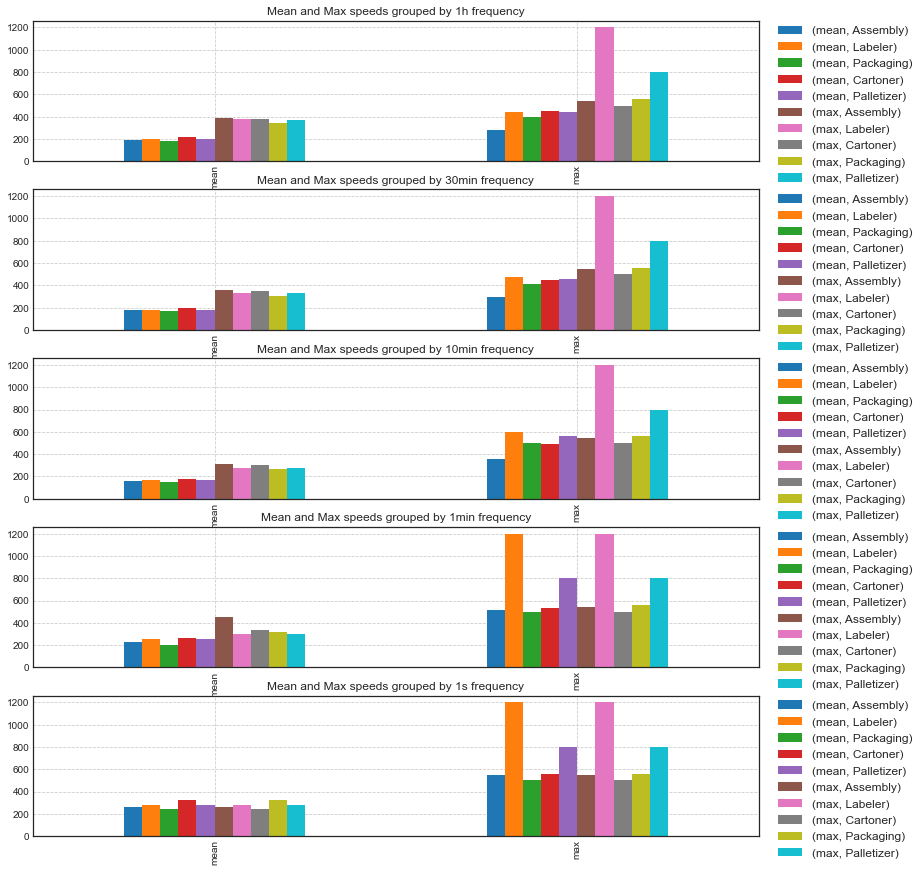

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# max speed for each our
freq=['1h','30min','10min','1min', '1s']
print('\nPeriod: {} to {}'.format(start_date, end_date))

fig, axs = plt.subplots(len(freq), 1, figsize=(13, 15))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for f in freq:
    max_hours = df_speed.groupby([pd.Grouper(freq=f),'Machine'])['Derived_Speed'].agg(['mean','max']).unstack()
    max_hours.columns = [('mean',   'Assembly'),
            ('mean',    'Labeler'),
            ('mean',  'Packaging'),
            ('mean',   'Cartoner'),
            ('mean', 'Palletizer'),
            ( 'max',   'Assembly'),
            ( 'max',    'Labeler'),
            ( 'max',   'Cartoner'),
            ( 'max',  'Packaging'),
            ( 'max', 'Palletizer')]

    max_hours.agg({'mean','max'}).sort_index(ascending=False).plot.bar(ax=axs[i])

    # plt.yscale('log')

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('Mean and Max speeds grouped by {} frequency'.format(f))
    plt.rc('legend', fontsize=12)    # legend fontsize
    #place legend outside top right corner of plot
#     handles, labels = axs[i].get_legend_handles_labels()
#     axs[i].legend(handles, labels)
    axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    i+=1

# f = '10min'
# df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack().reset_index()



In [ ]:
max_hours = df_speed.groupby([pd.Grouper(freq='1s'),'Machine'])['Derived_Speed'].agg(['mean','max']).unstack()

In [ ]:
max_hours.agg({'mean','max'})

mean                                                          max                                                 
        Assembly     Cartoner     Labeler   Packaging  Palletizer    Assembly     Cartoner     Labeler   Packaging  Palletizer
mean  257.909202   282.608594  246.821966  319.760061  283.215323  258.101256   282.612811  246.890833  319.760398  283.215323
max   544.000000  1200.000000  500.000000  560.000000  800.000000  544.000000  1200.000000  500.000000  560.000000  800.000000

In [ ]:
max_hours.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 862669 entries, 2021-08-01 00:07:42 to 2021-09-30 23:59:59
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   (mean, Assembly)    419589 non-null  float64
 1   (mean, Cartoner)    42682 non-null   float64
 2   (mean, Labeler)     240448 non-null  float64
 3   (mean, Packaging)   282761 non-null  float64
 4   (mean, Palletizer)  44064 non-null   float64
 5   (max, Assembly)     419589 non-null  float64
 6   (max, Cartoner)     42682 non-null   float64
 7   (max, Labeler)      240448 non-null  float64
 8   (max, Packaging)    282761 non-null  float64
 9   (max, Palletizer)   44064 non-null   float64
dtypes: float64(10)
memory usage: 72.4 MB


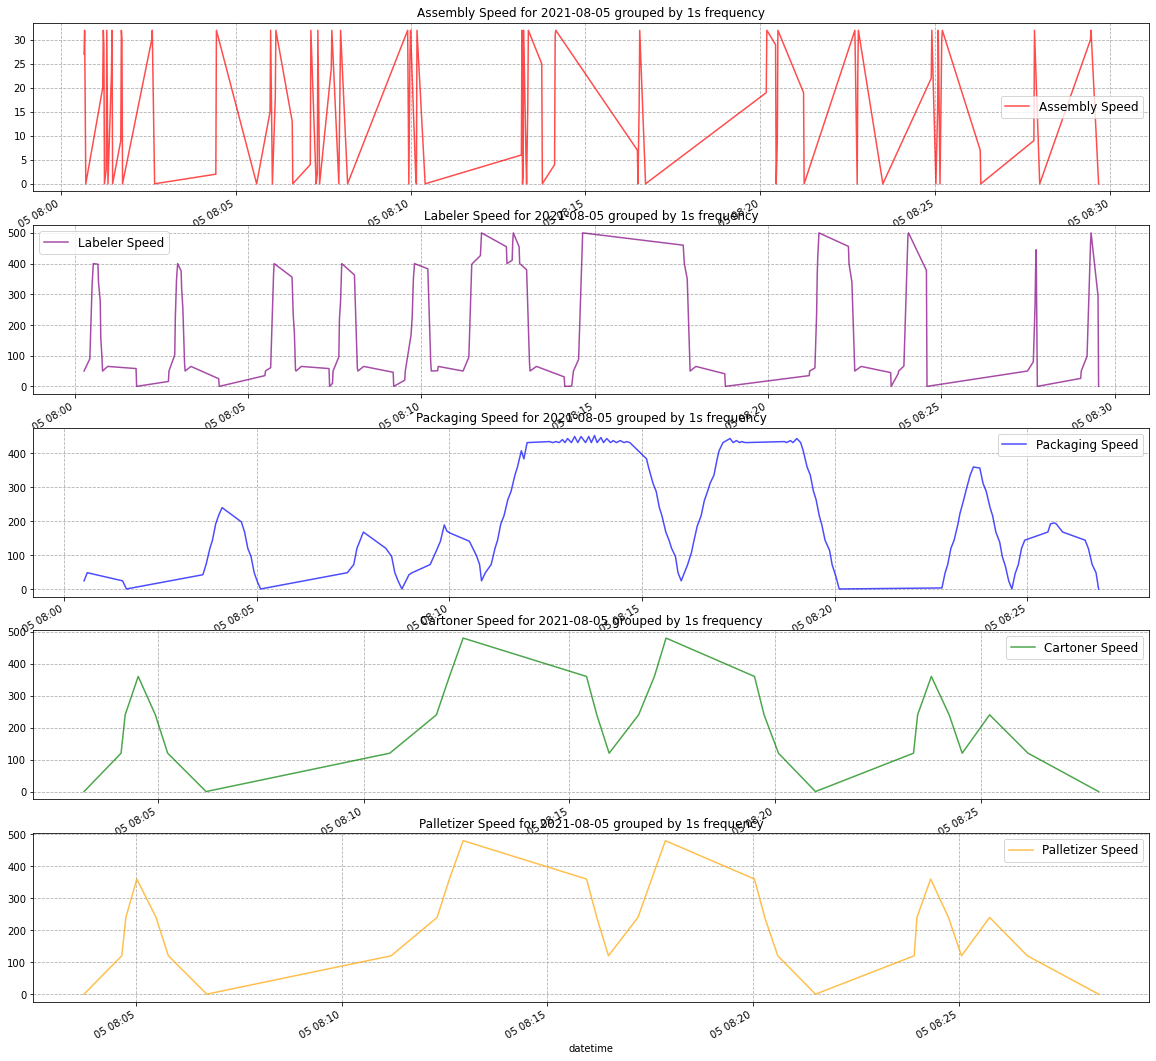

In [63]:
daterange = '2021-08-05'
times = ['08:00', '08:30']
freq='1s'

dates = group.loc[daterange]
dates = dates.between_time(times[0], times[1])

dates = dates.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
dates.set_index('datetime', inplace=True)


fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    dates['Derived_Speed'][dates.Machine == x].plot(color=colors[i], label=('{} Speed'.format(x)), ax=axs[i], alpha=0.7)
    # plt.yscale('log')

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Speed for {} grouped by {} frequency'.format(x, daterange, freq))
    plt.rc('legend', fontsize=12)    # legend fontsize
    axs[i].legend()
    i+=1

In [79]:
df_changeover3

,start,end,time_diff_mins
0,2021-08-02 22:47:04.100,2021-08-02 23:33:13.200,46
1,2021-08-03 19:48:39.600,2021-08-03 21:08:45.100,80
2,2021-08-04 00:56:14.200,2021-08-04 02:05:46.100,69
3,2021-08-04 07:01:24.900,2021-08-04 07:37:14.500,35
4,2021-08-05 20:07:04.200,2021-08-05 20:50:02.000,42
5,2021-08-06 00:30:29.400,2021-08-06 03:04:38.500,154
6,2021-08-06 11:04:49.200,2021-08-06 12:55:08.100,110
7,2021-08-07 01:48:36.400,2021-08-07 03:10:52.900,82
8,2021-08-10 09:33:14.700,2021-08-10 10:49:15.300,76
9,2021-08-12 10:17:53.000,2021-08-12 11:01:49.000,43


C:\Users\mark_\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


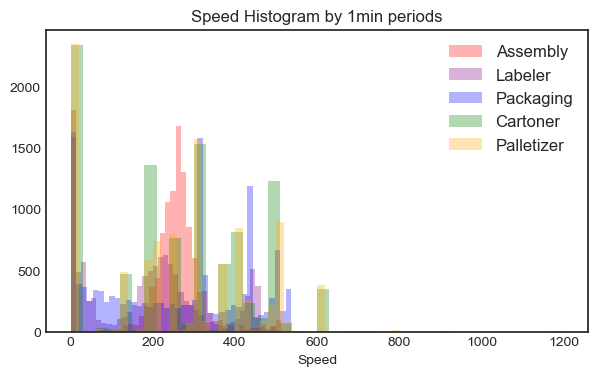

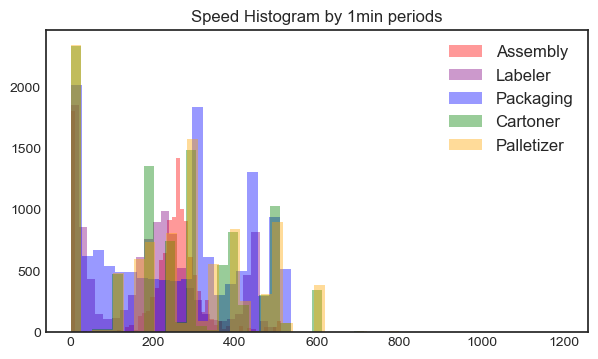

In [242]:
plt.subplots(figsize=(7,4), dpi=100)

freq='1min'

i=0
for x in machines:

    # data = df_speed[df_speed == x].Derived_Speed.sort_values(ascending=False)
    data = df_speed[df_speed.Machine == x].groupby([pd.Grouper(freq=freq)]).Derived_Speed.mean().reset_index()
    data.set_index('datetime', inplace=True)
    kwargs = dict(histtype='stepfilled', label=x, alpha=0.3, bins=40, color=colors[i])
    plt.hist(data, **kwargs)
    plt.legend()
    # plt.yscale('log')
    i+=1

plt.title('Speed Histogram by {} periods'.format(freq))
# plt.ylabel('{} count'.format(freq))
plt.xlabel('Speed')

plt.subplots(figsize=(7,4), dpi=100)
i=0
for x in machines:

    data = df_speed[df_speed.Machine == x].groupby([pd.Grouper(freq=freq)]).Derived_Speed.mean().reset_index()
    data.set_index('datetime', inplace=True)
    # data = df_speed.loc[df_speed.Machine == x, 'Derived_Speed'].sort_values(ascending=False)
    sns.distplot (data, color=colors[i], label=x, kde=False)
    i+=1

plt.title('Speed Distplot by {} periods'.format(freq))
plt.legend();


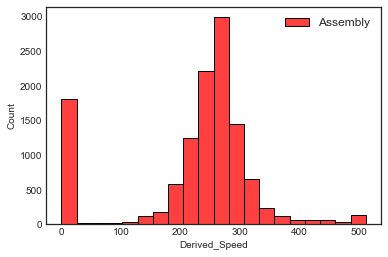

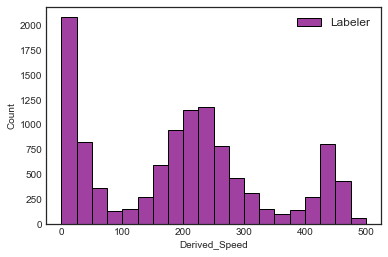

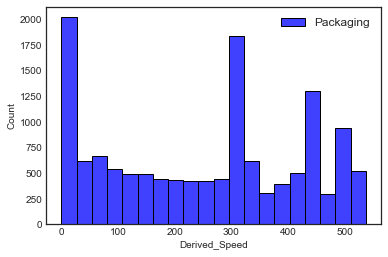

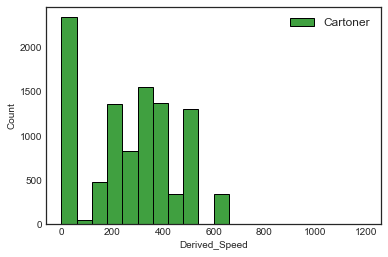

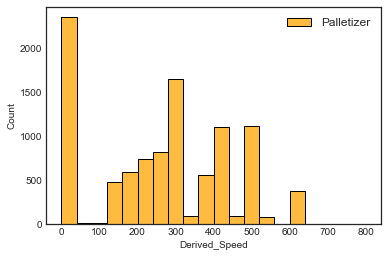

In [387]:
colors = ["red", "purple", "blue", "green", "orange"]

i=0
for x in machines:
    data = df_speed.groupby(['Machine', pd.Grouper(freq='1min')]).Derived_Speed.mean().reset_index()
    data.set_index('datetime', inplace=True)
    sns.histplot(data[data.Machine == x].Derived_Speed, kde=False, color=colors[i], bins=20, label=x)
    plt.legend()
    plt.show()
    i+=1

In [165]:
# drop data between 22:00 on Sat through to 06:00 on Monday, as Sunday is closed on AL6
# get Tues - fri data first
df_speed_no_sunday = df_speed[(df_speed.index.dayofweek > 0) & (df_speed.index.dayofweek < 5)]

# get Mon between 06:00 and 23:59
df_mon = df_speed[df_speed.index.dayofweek == 0]
df_mon = df_mon.between_time('06:00', '23:59')
df_speed_no_sunday = df_speed_no_sunday.append(df_mon)

# get saturday between 00:00 and 22:00
df_sat = df_speed[df_speed.index.dayofweek == 5]
df_sat = df_sat.between_time('00:00', '22:00')
df_speed_no_sunday = df_speed_no_sunday.append(df_sat)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Packaging'),
  Text(1, 0, 'Assembly'),
  Text(2, 0, 'Labeler'),
  Text(3, 0, 'Cartoner'),
  Text(4, 0, 'Palletizer')])

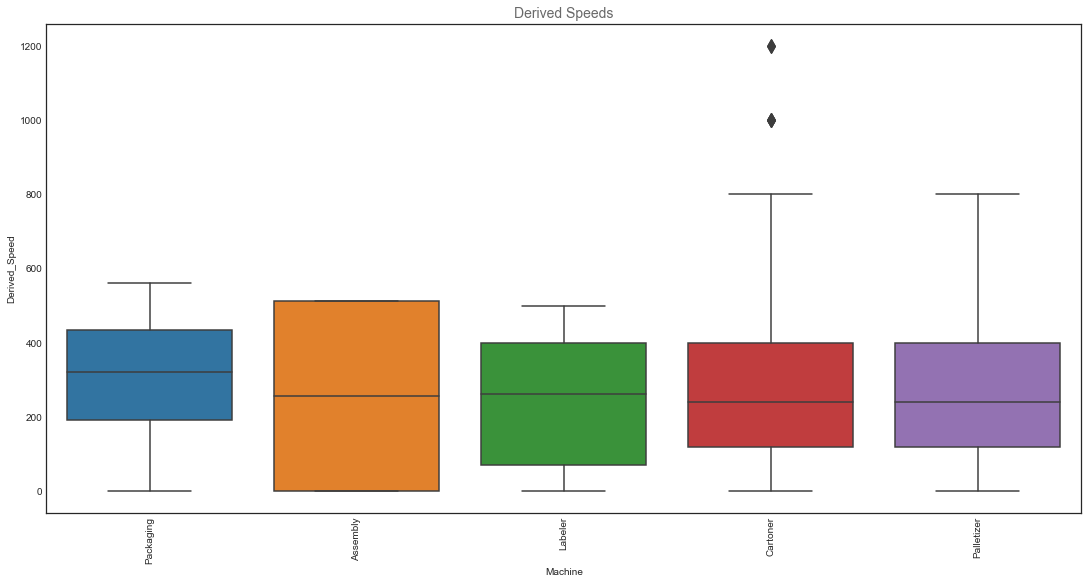

In [187]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(15, 8))

sns.boxplot(x='Machine', y='Derived_Speed', data=df_speed, whis=1.5, fliersize=10).set_title('Derived Speeds', color='dimgrey', size=14)
plt.xticks(rotation=90)

<AxesSubplot:xlabel='IP_TREND_VALUE', ylabel='Count'>

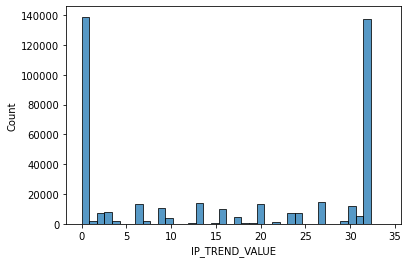

In [76]:
sns.histplot(df_speed['IP_TREND_VALUE'][df_speed.Machine == 'Assembly'])

<AxesSubplot:xlabel='IP_TREND_VALUE', ylabel='Count'>

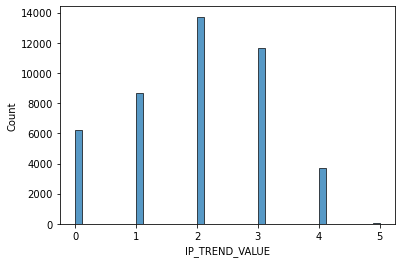

In [77]:
sns.histplot(df_speed['IP_TREND_VALUE'][df_speed.Machine == 'Palletizer'])

<AxesSubplot:xlabel='IP_TREND_VALUE', ylabel='Count'>

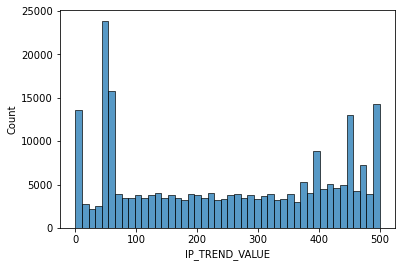

In [78]:
sns.histplot(df_speed['IP_TREND_VALUE'][df_speed.Machine == 'Labeler'])

In [147]:
df_speed.groupby([pd.Grouper(freq='D'), 'Machine', 'pens'])['Derived_Speed'].sum()

datetime    Machine     pens
2021-08-01  Assembly    5        714320.0
            Cartoner    5         59880.0
            Labeler     5        562084.0
            Packaging   5        561573.0
            Palletizer  5         65640.0
                                  ...    
2021-09-30  Assembly    5       2388528.0
            Cartoner    5        215000.0
            Labeler     5        986703.0
            Packaging   5       1175095.0
            Palletizer  5        216000.0
Name: Derived_Speed, Length: 279, dtype: float64